<a href="https://colab.research.google.com/github/ElZho/Translate-from-old-russian-language.Seq2seq-model./blob/main/Seq2Seq_translation_final_large_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sources:**

Baseline - [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial)

Embeddings -https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

https://python-school.ru/blog/word2vec-with-examples-in-gensim/

Dataloader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

Self attention and pad_packed_sequence https://discuss.pytorch.org/t/self-attention-on-words-and-masking/5671

https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html

scheduler https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In this notebook I try to use scheduler:
1. **I choose scheduler**, which can change learning rate due to loss result. It check loss changes during the training and make step if loss stop to improve.

*torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)*

It has lots of configurable parametrs.


In [ ]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm
from tqdm import tqdm

In [ ]:
import unicodedata
import string
import re
import random
import itertools

In [ ]:
import time
import math
from collections import defaultdict

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
import os
from pathlib import Path
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/NLP_translation/* . 

Mounted at /content/drive


In [ ]:
from preprocessing import prepareData, readLangs, tensorsFromPair, tensorFromSentence

In [ ]:
SOS_token = 1
EOS_token = 0

In [ ]:
from model import EncoderRNN, AttnDecoderRNN, TONModel

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Make helper functions.

In [ ]:
#function to check time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
#function to plot loss curves
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(10,5))

    # plt.subplot(1,3,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

Create a traning model using dataloader.
Made changes: 
1. epoch iteration. Each epoch is train on all train dataset and validate on test dataset.
2. Encoder and decoder comunication is in model. In training model function I just pass input tensor, output tensor and input sentence length into model and get decoder output out.
3. I use batches to load data, so outputs and target have to be transformed to pass to loss function.
4. I collect train and validation loss for each epoch into defaultdict.
5. I plot train and validation loss after the training.
6. I save best model during the training.

In [ ]:
#model with data loader
def train_modelIters(model, optimizer, loader, test_loader, criterion, num_epochs=6, scheduler=None):
    start = time.time() #start time
    itog_losses = []
    best_loss=np.inf #initiate best loss to check and save model with best loss.

    history = defaultdict(lambda: defaultdict(list))  #dictionry to collect losses  
      
    for epoch in tqdm(range(num_epochs), desc='epochs'):
      model.train(True)      

      plot_losses = []
      #print_loss_total = 0  
      plot_loss_total = 0

      val_losses = []
      val_loss_total = 0  
      
      #train loop
      for batch in tqdm(loader, desc='train sample batches'):
          
          input_tensor = batch[0].to(device)
          input_len=batch[1]          #true length  of sentences in batches withput padding
          target_tensor = batch[2].to(device)                           
         
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0])
          
          target_tensor = target_tensor.view(-1) #change dimantion in one size
          output_dim = decoder_outputs.shape[-1]  #change dimantion in one size
          decoder_outputs=decoder_outputs.view(-1, output_dim)  #change dimantion in one size
          
          loss = criterion(decoder_outputs, target_tensor)      #calculate loss
          
          loss.backward(retain_graph=True)    
          optimizer.step()
          optimizer.zero_grad()                   
          
          plot_loss_total += loss.item() #collect losses
          
      plot_loss_avg = plot_loss_total /  len(loader)
      history['loss']['train'].append(plot_loss_avg)
      
      model.train(False)
      #validation loop
      for batch in tqdm(test_loader, desc='validation sample batches'):
        
        input_tensor = batch[0].to(device)
        input_len=batch[1]
        target_tensor = batch[2].to(device)
               
        with torch.no_grad():
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0],
                                  evalute=True)
          
          target_tensor = target_tensor.view(-1)
          output_dim = decoder_outputs.shape[-1]            
          decoder_outputs=decoder_outputs.view(-1, output_dim)    
          
          val_loss = criterion(decoder_outputs, target_tensor) # calculate validation loss          
          val_loss_total+= loss.item() #collect loss item
          if scheduler!=None:
            scheduler.step(val_loss)

      val_loss_avg = val_loss_total / len(test_loader)    
      history['loss']['val'].append(val_loss_avg)
      print('Epoch train loss', plot_loss_avg, end='\n')
      print('Epoch val_loss', val_loss_avg, end='\n')

      if val_loss_avg<best_loss: #save best model
        best_loss=val_loss
        torch.save(model, '/content/drive/MyDrive/NLP_translation/best_model_eng.pt')

    plot_learning_curves(history) #plot loss curves
    return 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def evaluateRandomly(model, pairs, input_lang, output_lang, n=10):
    for i in range(n):
        outputs=[]
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        input_tensor = tensorFromSentence(input_lang, pair[0], config['MAX_LENGTH'])
        input_len=torch.tensor([len(pair[0].split(' '))], dtype=torch.int64)
        target_tensor=tensorFromSentence(output_lang, pair[1], config['MAX_LENGTH'])
                
        output_words, _ = model(input_tensor.reshape(1,config['MAX_LENGTH']), input_len, target_tensor.reshape(1,config['MAX_LENGTH']), evalute=True)    
        
        result=output_words.argmax(2).detach()
        result=result.squeeze(0)
        
        for idx in range(result.shape[0]):
            tok=train_output_lang.index2word[result[idx].item()]
            if tok=='EOS':
              break
            outputs.append(tok) 
        #print(bleu_score(result.tolist(), target_tensor.tolist()))      
        output_sentence = ' '.join(outputs)
        print('<', output_sentence)
        print('')
        
        print('Blue score of this sentence  - ', sentence_bleu(outputs, pair[1].split(' ')))
        print('')
        print('======================================')

In [ ]:
def evaluate(model, pairs, input_lang=train_input_lang, output_lang=train_output_lang):
    outputs=[]        
    input_tensor = tensorFromSentence(input_lang, pairs[0], config['MAX_LENGTH'])
    input_len=torch.tensor([len(pairs[0].split(' '))], dtype=torch.int64)
    target_tensor=tensorFromSentence(output_lang, pairs[1], config['MAX_LENGTH'])
                
    output_words, attention = model(input_tensor.reshape(1,config['MAX_LENGTH']), input_len, target_tensor.reshape(1,config['MAX_LENGTH']), evalute=True)    
        
    result=output_words.argmax(2).detach()
    result=result.squeeze(0)
        
    for idx in range(result.shape[0]):
        tok=train_output_lang.index2word[result[idx].item()]
        if tok=='EOS':
          break
        outputs.append(tok) 
             
        output_sentence = ' '.join(outputs)
    return    outputs,  attention

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze().cpu().detach()
    a=torch.zeros(len(attention), len(attention))
    for idx in range(len(attention)):
      a[idx,idx]=attention[idx]
    cax = ax.matshow(a.numpy(), cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
    
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluateAndShowAttention(input_sentence, model=model):
    output_words, attentions = evaluate(model, input_sentence)
    print('input =', input_sentence[0])
    print('output =', ' '.join(output_words))
    attentions=attentions.detach()
    
    display_attention(input_sentence[0].split(' '), output_words, attentions)

First set up parametrs.

In [ ]:
config = {  
    #'path'  :'/content/drive/MyDrive/NLP_translation/old_slav.txt', #old slavenic - rus
    'path':'/content/rus.txt', #rus-eng
    'MAX_LENGTH':15,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':256, # for short datasets use batch_size - 8, for big dataset - 128

    'teacher_forcing_ratio': 0.5,
    'hidden_size':256,
    'num_epochs':25,
    
    'lr': 0.001
}

In [ ]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('old_rus', 'new_rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...


100%|██████████| 440220/440220 [00:00<00:00, 2544913.95it/s]


Read 308153 sentence pairs train
Read 132066 sentence pairs test
Trimmed to 304559 sentence train pairs
Trimmed to 130531 sentence test pairs
Counting words...
Counted words train:
old_rus 15845
new_rus 48372
Counted words test:
old_rus 12106
new_rus 33440
['tom wants to eat ', 'том хочет есть ', 'cc-by 2 0 (france) attribution: tatoeba org #8897171 (ck) & #6311914 (marafon)']


Check lengths of sentences

In [ ]:
#max length of train sentence
len_train=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in train_pairs)
max(len_train)

[14, 14]

In [ ]:
#max length of test sentence
max([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in test_pairs)

[46, 45]

In [ ]:
def len_pair(pair):
  len_0=len(pair[0].split(' '))
  len_1=len(pair[1].split(' '))
  return len_0, len_1
len_train_old=[] 
len_train_new=[] 
for pair in train_pairs:  
  old, new=len_pair(pair)
  len_train_old.append(old)
  len_train_new.append(new)

Plot histogramm for length of source sentence

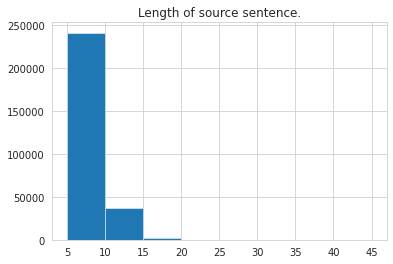

In [ ]:
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25, 35, 40, 45], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');



Plot histogramm for length of target sentence

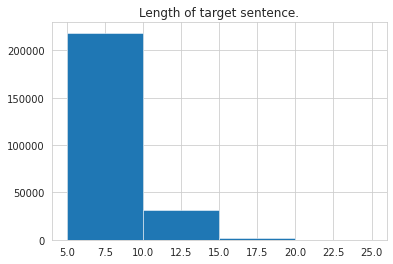

In [ ]:
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of target sentence.');

Make DataLoaders for train and test sentences.

For use dataloader I add padding sentences to max length in tensorFromSentence. 
To use pad_packed_sentence I add get_len function to get true length of sentence.

In [ ]:
training_pairs = [tensorsFromPair(train_pair, train_input_lang, train_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]
testing_pairs = [tensorsFromPair(test_pair, test_input_lang, test_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=False)   #Test dataloader without shuffling pairs to have comparable results for validation loop                                         

100%|██████████| 130531/130531 [00:09<00:00, 13323.91it/s]


Train model using Adam optimizer, NLLLos and scheduler

train sample batches: 100%|██████████| 1190/1190 [06:13<00:00,  3.18it/s]

validation sample batches: 100%|██████████| 510/510 [00:41<00:00, 12.25it/s]


Epoch train loss 4.530550017276732
Epoch val_loss 3.388214111328125


train sample batches: 100%|██████████| 1190/1190 [06:14<00:00,  3.18it/s]

validation sample batches: 100%|██████████| 510/510 [00:41<00:00, 12.28it/s]


Epoch train loss 2.9732309403539707
Epoch val_loss 2.737356662750244


train sample batches: 100%|██████████| 1190/1190 [06:14<00:00,  3.17it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 12.13it/s]


Epoch train loss 2.427990982312114
Epoch val_loss 2.3855621814727783


train sample batches: 100%|██████████| 1190/1190 [06:15<00:00,  3.17it/s]

validation sample batches: 100%|██████████| 510/510 [00:41<00:00, 12.20it/s]


Epoch train loss 2.133778590414704
Epoch val_loss 2.17337965965271


train sample batches: 100%|██████████| 1190/1190 [06:15<00:00,  3.17it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 12.03it/s]


Epoch train loss 1.9480121933111623
Epoch val_loss 2.030038595199585


train sample batches: 100%|██████████| 1190/1190 [06:16<00:00,  3.16it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.96it/s]


Epoch train loss 1.825467113486859
Epoch val_loss 1.9294204711914062


train sample batches: 100%|██████████| 1190/1190 [06:16<00:00,  3.16it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 12.06it/s]


Epoch train loss 1.7468556645537625
Epoch val_loss 1.667189121246338


train sample batches: 100%|██████████| 1190/1190 [06:16<00:00,  3.16it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 12.14it/s]


Epoch train loss 1.6855623526733463
Epoch val_loss 1.6939903497695923


train sample batches: 100%|██████████| 1190/1190 [06:16<00:00,  3.16it/s]

validation sample batches: 100%|██████████| 510/510 [00:43<00:00, 11.81it/s]


Epoch train loss 1.6335307222454487
Epoch val_loss 1.6896792650222778


train sample batches: 100%|██████████| 1190/1190 [06:17<00:00,  3.15it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.96it/s]


Epoch train loss 1.5901144691876004
Epoch val_loss 1.610687494277954


train sample batches: 100%|██████████| 1190/1190 [06:17<00:00,  3.15it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.93it/s]


Epoch train loss 1.5522268459576518
Epoch val_loss 1.7747912406921387


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.86it/s]


Epoch train loss 1.5189979982977153
Epoch val_loss 1.543933391571045


train sample batches: 100%|██████████| 1190/1190 [06:19<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 12.04it/s]


Epoch train loss 1.4910641197396928
Epoch val_loss 1.5778143405914307


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.91it/s]


Epoch train loss 1.4644752108750223
Epoch val_loss 1.5617375373840332


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.86it/s]


Epoch train loss 1.4408827218688836
Epoch val_loss 1.4487864971160889


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.92it/s]


Epoch train loss 1.4206626194865764
Epoch val_loss 1.4099396467208862


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 12.12it/s]


Epoch train loss 1.400628201801236
Epoch val_loss 1.5005704164505005


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 12.10it/s]


Epoch train loss 1.3824634785411738
Epoch val_loss 1.3477293252944946


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:43<00:00, 11.76it/s]


Epoch train loss 1.3669673934704116
Epoch val_loss 1.4534977674484253


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:43<00:00, 11.79it/s]


Epoch train loss 1.3524770734690819
Epoch val_loss 1.4003711938858032


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.88it/s]


Epoch train loss 1.3384268884899235
Epoch val_loss 1.3953559398651123


train sample batches: 100%|██████████| 1190/1190 [06:19<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:43<00:00, 11.86it/s]


Epoch train loss 1.3238760366159328
Epoch val_loss 1.228938341140747


train sample batches: 100%|██████████| 1190/1190 [06:18<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.95it/s]


Epoch train loss 1.311946855573093
Epoch val_loss 1.353827953338623


train sample batches: 100%|██████████| 1190/1190 [06:19<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:43<00:00, 11.78it/s]


Epoch train loss 1.2990240360508445
Epoch val_loss 1.3583238124847412


train sample batches: 100%|██████████| 1190/1190 [06:19<00:00,  3.14it/s]

validation sample batches: 100%|██████████| 510/510 [00:42<00:00, 11.88it/s]


Epoch train loss 1.2903410525882946
Epoch val_loss 1.344794511795044


epochs: 100%|██████████| 25/25 [2:55:16<00:00, 420.66s/it]


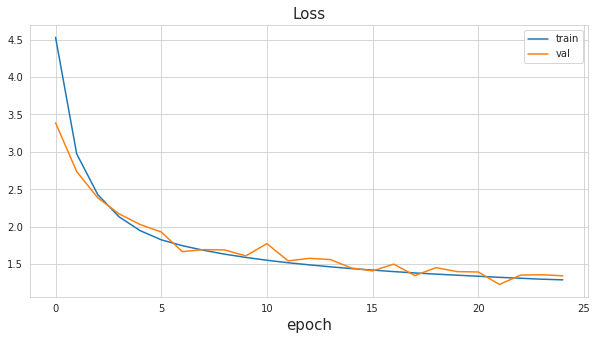

In [ ]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
#                             factor=0.95, threshold=0.1, min_lr=2e-5, verbose=True)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

In [ ]:
model_1=torch.load('/content/drive/MyDrive/NLP_translation/best_model_eng.pt')

In [ ]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang)

> are we all going to die 
= мы все умрем 
< мы все умрем  

Blue score of this sentence  -  0

> mary loves to ride her horse 
= мэри любит кататься на своеи лошади 
< мэри любит кататься на лошади          

Blue score of this sentence  -  0

> tom used to be poor 
= раньше том был бедным 
< том раньше был бедным           

Blue score of this sentence  -  0

> tom isn't in a big hurry 
= том не очень спешит 
< том не спешит            

Blue score of this sentence  -  0

> can you give tom something for the pain 
= ты можешь дать тому что-нибудь от боли 
< ты можешь дать тому боли от   боли

Blue score of this sentence  -  0

> your parents will never allow you to go 
= родители никогда не позволят вам поехать 
< родители никогда не позволят вам никогда тебе 

Blue score of this sentence  -  0

> tom is focused 
= том сосредоточен 
< том сосредоточен  

Blue score of this sentence  -  0

> tom was shy 
= том был застенчивым 
< том был застенчивым  

Blue score of this sentence  -  0

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluateRandomly(model_1, train_pairs, train_input_lang, train_output_lang)

> i want to ask you some more questions 
= я хочу задать вам еще несколько вопросов 
< сделали знали знали знали сделали часов знали жизни родственники

Blue score of this sentence  -  0

> can you try this number again 
= вы можете еще раз попробовать позвонить по этому номеру 
< бананы родственники родственники родственники родственники родственники родственники родственники нашли родственники родственники

Blue score of this sentence  -  0

> nobody understands it 
= никто этого не понимает 
< знали слова спал слова спал слова спал слова спал слова спал слова спал слова спал

Blue score of this sentence  -  0

> we're working on that 
= мы работаем над этим 
< попытаться родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники

Blue score of this sentence  -  0

> you should've told me that yesterday 
= вам следовало вчера мне об этом сказать 
< мои родственни

In [ ]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang)

> she doesn't like living downtown 
= еи не нравится жить в центре города 
< куда чего того            

Blue score of this sentence  -  0

> the boy made his parents happy 
= мальчик сделал своих родителеи счастливыми 
< ты      

Blue score of this sentence  -  0

> i'll try to do it as fast as i can 
= я постараюсь сделать это как можно скорее 
< может точно случится случится случится случится случится случится случится случится случится случится случится случится случится

Blue score of this sentence  -  0.5946035575013605

> please leave everything to us 
= пожалуиста  предоставьте все нам 
< расскажи  что  что  что  что  что  что  что

Blue score of this sentence  -  0

> tom ate a quesadilla 
= том съел кесадилью 
< одним    

Blue score of this sentence  -  0

> what were you doing in australia 
= что ты делала в австралии 
< некоторые    кого-то  посмотрим

Blue score of this sentence  -  0

> i missed a lot 
= я многое пропустил 
< том   приити 

Blue score of this sentence  

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluateRandomly(model_1, test_pairs, test_input_lang, test_output_lang)

> his girlfriend has lost weight 
= его девушка похудела 
< "нет" что родственники дедушка родственники дедушка родственники дедушка родственники дедушка родственники дедушка родственники дедушка родственники

Blue score of this sentence  -  0

> let me think about it a bit longer 
= даи мне еще немного подумать 
< томе гражданин гражданин все стар стар стар

Blue score of this sentence  -  0

> something must be done 
= надо что-то делать 
< в родственники в в родственники

Blue score of this sentence  -  0

> i want to walk home 
= я хочу поити домои пешком 
< знали дает родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники родственники

Blue score of this sentence  -  0

> i had a donut and a cup of coffee 
= я взял пончик и чашку кофе 
< знали что знали что знали что знали что знали что знали что знали что знали

Blue score of this sentence  -  0.6147881529512643

> i believe in yo

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


input = i shouldn't have let you drive 
output = мне не стоило пускать тебя за руль  руль  руль  руль  руль


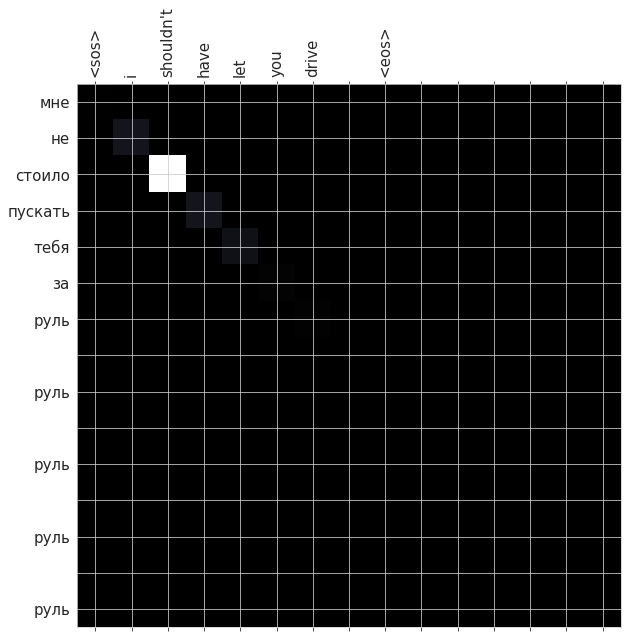

In [ ]:
evaluateAndShowAttention(random.choice(train_pairs), model=model)

input = we'd like to speak with you 
output = вид родственники родственники родственники родственники знали родственники родственники


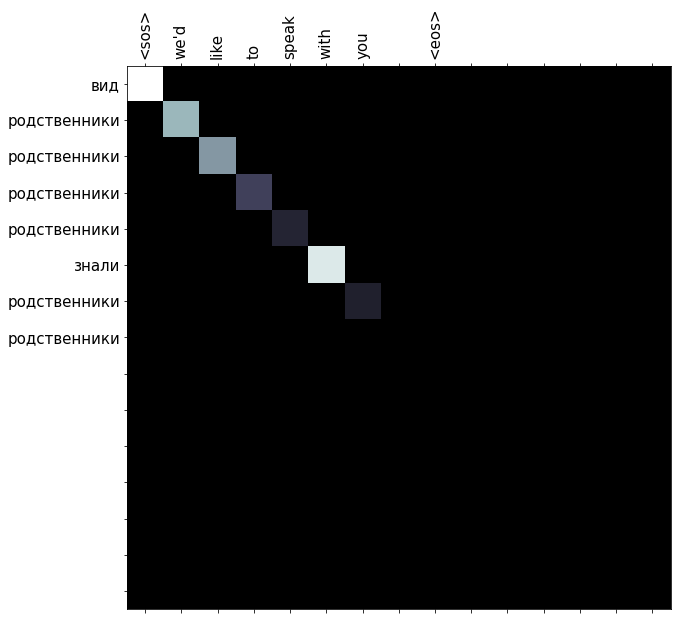

In [ ]:
evaluateAndShowAttention(random.choice(train_pairs), model=model_1)